<a href="https://colab.research.google.com/github/diputs03/AI-Studies/blob/main/From-tensorflow-mnist-tutorial/keras_01_mnist_changed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
BATCH_SIZE = 128
EPOCHS = 10

In [2]:
from matplotlib import pyplot as plt

In [3]:
# Set random seed for reproducibility
tf.random.set_seed(42)

In [4]:
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Flatten images to 1D vector of 784 features (28*28)
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
#@title trying to right visualization utils

"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):

  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)

  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, validation_labels in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      break
    for training_digits, training_labels in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      break

  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = batch_train_ds.make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])

  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)

  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display.display(fig)

# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

In [47]:
class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()

    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)

    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)

    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)

    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)

    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

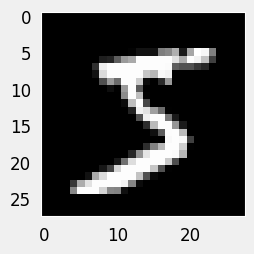

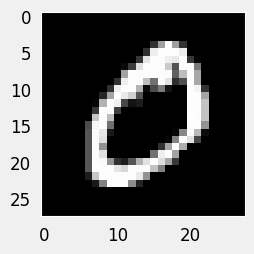

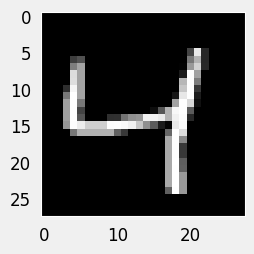

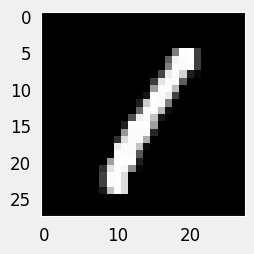

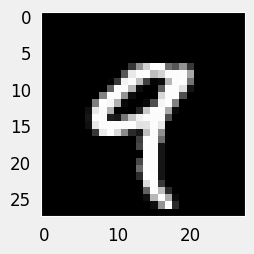

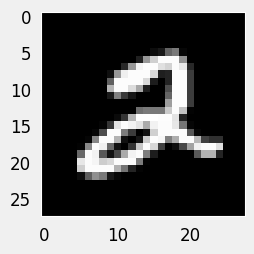

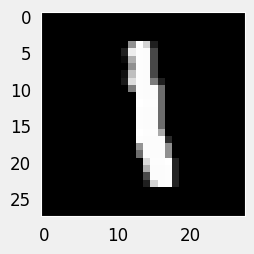

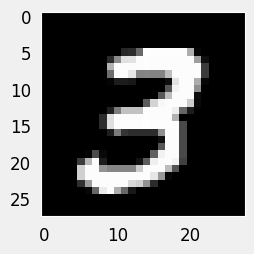

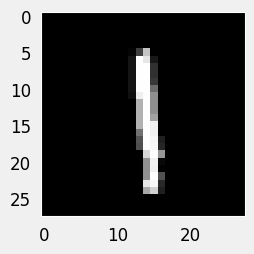

In [7]:
from matplotlib import pyplot
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(x_train[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
  pyplot.show()

In [51]:
# Build the neural network model

#Layers

input = tf.keras.layers.Input(shape=(28*28, ))
layers = [tf.keras.layers.Dense(10, activation='softmax')]
model = tf.keras.models.Sequential()
model.add(input)
for layer in layers:
  model.add(layer)

In [52]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [53]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Train the model
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2
)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6922 - loss: 1.1466 - val_accuracy: 0.8954 - val_loss: 0.4122
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8924 - loss: 0.4101 - val_accuracy: 0.9108 - val_loss: 0.3364
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9067 - loss: 0.3451 - val_accuracy: 0.9162 - val_loss: 0.3091
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9131 - loss: 0.3177 - val_accuracy: 0.9199 - val_loss: 0.2948
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9165 - loss: 0.3019 - val_accuracy: 0.9214 - val_loss: 0.2859


In [55]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9117 - loss: 0.3272
Test accuracy: 0.9218


In [29]:
def decode(y_hat):
  k=0
  maximum=0
  for i in range(len(y_hat)):
    if y_hat[i]>maximum:
      k=i
      maximum=y_hat[i]
  return k

[4.8923393e-05 2.7967372e-08 1.1528471e-04 3.9683660e-03 4.4495346e-06
 3.9683542e-05 1.1947908e-07 9.9457872e-01 7.2289127e-05 1.1720872e-03]
[1.5667641e-03 5.8489528e-05 9.7863859e-01 3.1797022e-03 4.6481155e-10
 4.6890527e-03 1.1326668e-02 2.2786736e-11 5.4066896e-04 2.3226406e-08]
[1.5544094e-04 9.5519036e-01 1.6059220e-02 6.9510201e-03 6.1510573e-04
 1.4719442e-03 3.7733174e-03 4.6576303e-03 9.7206337e-03 1.4052691e-03]
[9.9927276e-01 1.2777520e-09 8.6654203e-05 1.3981745e-05 1.4930261e-07
 2.7784376e-04 1.7412391e-04 1.1176966e-04 3.8689603e-05 2.4046416e-05]
[1.1984290e-03 1.1750004e-05 5.5971094e-03 2.8034084e-04 9.3651927e-01
 3.7035104e-04 4.9538910e-03 6.0987389e-03 1.0783085e-02 3.4186982e-02]
[1.66723621e-05 9.75754440e-01 4.41679917e-03 4.79642767e-03
 1.18023054e-04 1.51216169e-04 2.17019246e-04 5.51792560e-03
 7.33816298e-03 1.67324382e-03]
[1.6750429e-05 8.5865231e-06 5.3469421e-06 6.7733257e-04 9.3938518e-01
 9.2216507e-03 2.8344366e-04 1.9190294e-03 3.2919496e-02 1.5

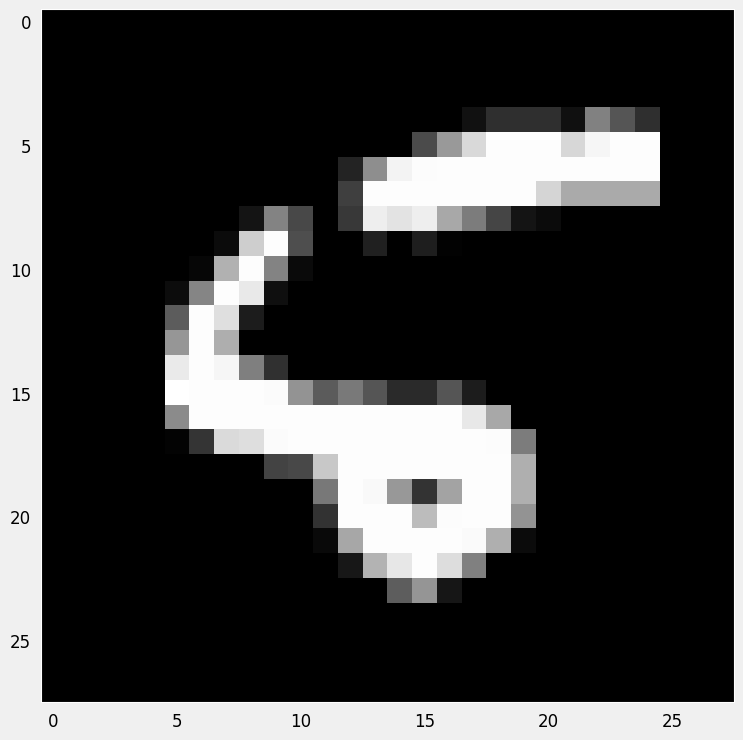

[2.0282370e-05 6.4956488e-08 8.9675910e-07 1.9292245e-05 2.2322901e-02
 1.0382925e-04 3.2748248e-05 7.7575728e-02 2.8193935e-03 8.9710486e-01]
[9.7461730e-01 1.0268946e-08 2.1982847e-03 6.9515151e-04 1.2799743e-06
 1.3377416e-02 1.4756517e-04 6.6592355e-07 8.9616440e-03 5.9460109e-07]
[7.9264576e-03 1.9414860e-04 6.9674999e-02 1.0339159e-02 3.0416108e-03
 1.0780644e-03 7.8684539e-01 8.0563696e-05 1.1956295e-01 1.2566991e-03]
[2.1485830e-04 1.8596331e-06 1.5946734e-04 7.0427119e-04 2.8997676e-02
 6.6614483e-04 2.1731987e-04 4.2097211e-02 4.0519661e-03 9.2288929e-01]
[9.9682271e-01 1.9416131e-09 1.0632901e-04 1.9749166e-05 3.6603251e-06
 1.0387828e-03 2.7199931e-06 2.0981337e-05 1.7336269e-03 2.5139158e-04]
[8.8024285e-07 9.9249762e-01 4.4438042e-04 4.4177501e-03 3.6915760e-06
 1.1538058e-04 2.0858640e-04 7.1481736e-05 1.9045515e-03 3.3558341e-04]
[4.3700724e-03 7.4221680e-05 3.9092875e-03 5.2002806e-02 3.7512893e-04
 8.7873369e-01 3.0412609e-04 6.2492152e-05 6.0136367e-02 3.1757405e-05]

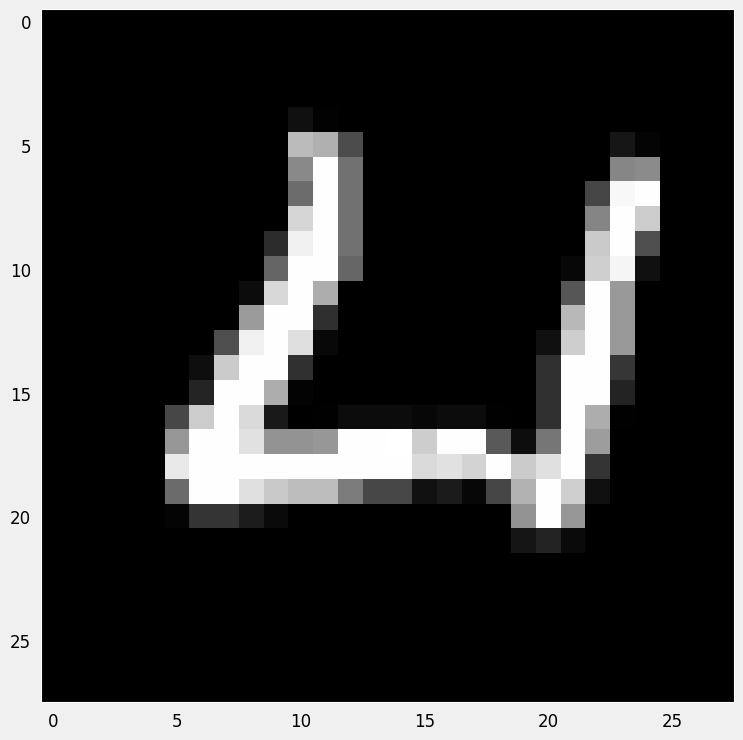

[2.0873460e-05 1.2750536e-06 1.8568330e-03 4.8074201e-03 2.4122135e-05
 2.1361939e-05 2.8941591e-07 9.8888212e-01 4.7934591e-04 3.9062975e-03]
[3.1791418e-04 1.2503092e-05 9.9555713e-01 1.4429340e-03 4.5321494e-07
 1.6492778e-03 7.5773096e-05 1.7768069e-07 9.4387203e-04 2.4638201e-08]
[3.0563446e-05 8.0027512e-08 6.1022164e-04 1.0240304e-02 3.9753158e-06
 5.2016905e-05 1.6842421e-06 9.8335475e-01 6.1524875e-04 5.0910907e-03]
[1.6969783e-06 9.9084091e-01 2.0193962e-04 2.1243610e-03 2.5899346e-05
 9.4614568e-04 2.5002245e-04 4.4187871e-04 4.4946717e-03 6.7244004e-04]
[3.1917054e-02 3.7711021e-03 5.5276042e-01 3.2404459e-01 2.7426088e-07
 3.9725572e-02 8.9925407e-03 2.1224105e-05 3.8689271e-02 7.7969467e-05]
[3.5508497e-06 9.7619617e-01 6.6446408e-04 3.0438202e-03 3.2575854e-06
 4.0300805e-04 5.8566628e-04 3.9779068e-05 1.8606944e-02 4.5328788e-04]
[4.6838255e-04 9.1844857e-01 1.5401830e-02 1.6954267e-02 6.2464684e-04
 6.3078669e-03 8.1566591e-03 6.9527593e-03 1.7605720e-02 9.0791276e-03]

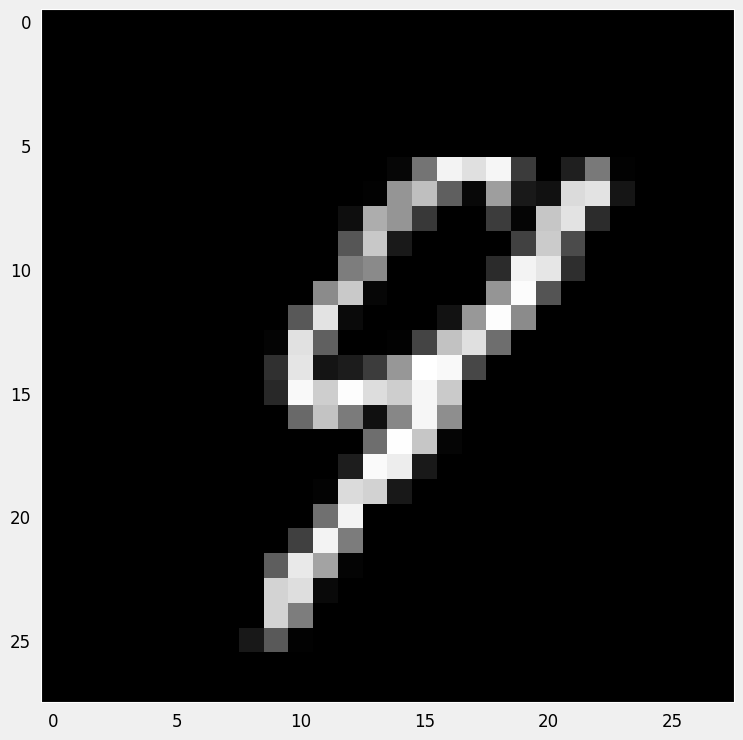

[3.1088297e-05 3.2214673e-06 4.2290081e-05 9.8777115e-01 4.2371016e-07
 8.3393203e-03 2.1230358e-07 2.1292416e-03 9.7944413e-04 7.0345099e-04]
[2.4129164e-08 9.8665071e-01 4.9393234e-04 1.1838002e-03 3.6401500e-05
 5.0284277e-04 3.8262783e-04 7.4533168e-06 1.0597762e-02 1.4452125e-04]
[5.18902425e-06 5.73035459e-06 6.74763123e-06 1.03636424e-07
 9.90933299e-01 9.53100141e-07 2.37764348e-03 3.03419947e-04
 2.65145994e-04 6.10169116e-03]
[5.6395980e-05 7.3616546e-01 3.1416253e-03 1.0078536e-01 4.5174952e-03
 4.3902297e-02 3.0093838e-03 1.8585179e-02 5.0665200e-02 3.9171509e-02]
[7.5554699e-06 5.2617647e-04 7.0405426e-03 1.8779749e-02 2.6030402e-04
 9.0682425e-04 7.8421261e-04 9.6188217e-01 6.9461321e-03 2.8663387e-03]
[3.6132904e-03 7.5693038e-06 4.1329050e-03 5.3626359e-06 5.9264876e-05
 1.2846807e-02 9.7879148e-01 1.4208696e-07 5.4160063e-04 1.5671588e-06]
[1.0793742e-06 3.6688397e-07 1.4137456e-04 2.6577178e-05 4.3247049e-03
 8.9819355e-07 5.4587908e-06 8.8709556e-03 9.7856310e-04 9.8

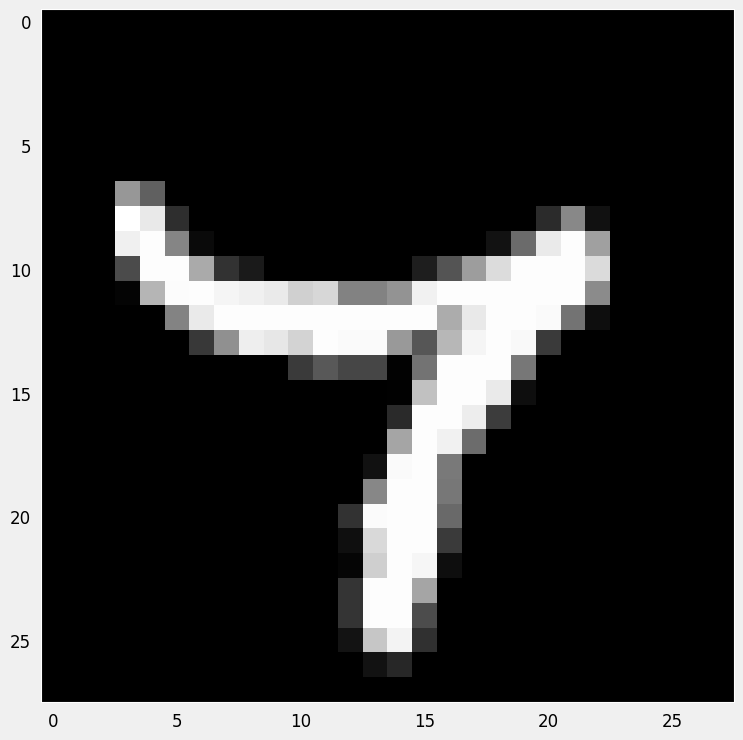

[3.2899989e-05 2.5608565e-03 1.7082987e-02 2.1574970e-03 1.0894767e-01
 2.1059134e-04 2.0925952e-03 1.4497922e-03 2.3239093e-02 8.4222609e-01]
[7.4220574e-01 9.9417065e-08 9.0609677e-02 1.5932652e-01 5.4437550e-07
 4.8419954e-03 3.6868241e-05 1.9421844e-03 7.8321144e-04 2.5311252e-04]
[2.6534959e-03 2.5043459e-05 3.5494915e-05 5.6578625e-05 1.3490563e-03
 9.6614653e-01 1.1736978e-04 2.2050646e-05 2.9352397e-02 2.4187303e-04]
[2.6164769e-06 1.1154248e-06 3.9950764e-04 1.1473447e-02 2.6510925e-05
 1.5423073e-02 9.4354903e-07 7.7748176e-05 9.6896029e-01 3.6346787e-03]
[6.7190812e-03 1.8748602e-05 4.0403084e-04 7.6073329e-03 1.5239351e-03
 9.3674564e-01 4.5733273e-04 8.9350280e-05 4.2175628e-02 4.2589190e-03]
[2.0039626e-05 4.5246143e-08 1.3078550e-04 3.1330885e-07 2.4521591e-03
 7.0695191e-05 9.9715036e-01 5.1341425e-07 9.8756718e-05 7.6393524e-05]
[2.8979228e-05 5.3203344e-09 1.9025871e-04 4.9252115e-08 3.1340711e-05
 4.7480105e-05 9.9968672e-01 2.6094600e-09 1.4726771e-05 3.6848274e-07]

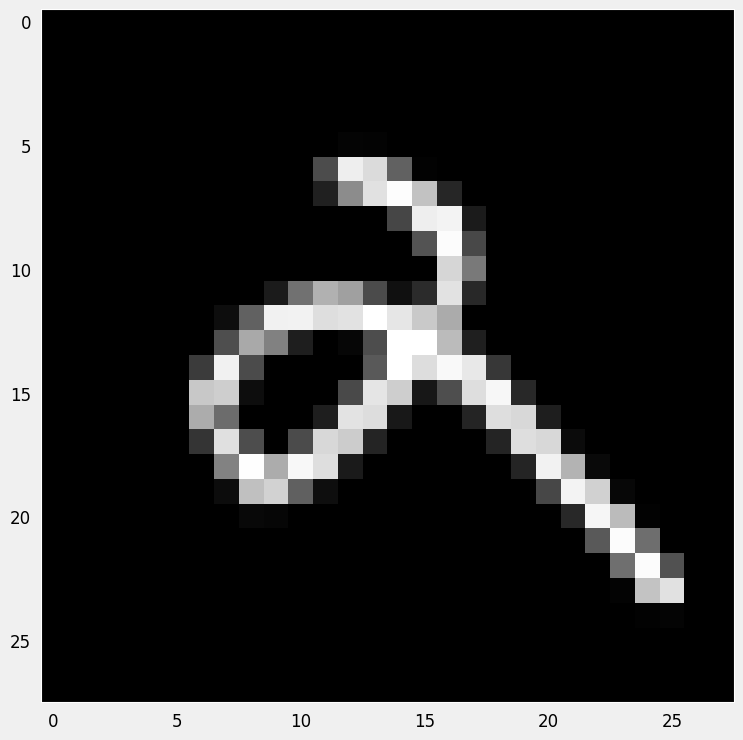

[2.87255796e-04 7.09254164e-06 2.25079828e-03 2.34526605e-03
 1.19585834e-01 1.26055861e-03 1.76186825e-03 6.78565295e-04
 2.32620332e-02 8.48560691e-01]
[2.8256632e-03 1.1372809e-05 1.3754649e-01 1.7379776e-02 5.1717591e-03
 2.1686072e-03 9.5191990e-06 2.5588640e-03 3.8449568e-01 4.4783232e-01]
[2.2810478e-02 1.1267754e-05 6.0507300e-04 4.7268717e-05 9.2652664e-03
 9.2376161e-01 2.5677864e-04 2.7448777e-04 4.1580930e-02 1.3868249e-03]
[1.5083185e-02 3.1014183e-04 9.5847882e-03 9.5942952e-02 5.9486123e-05
 6.1075008e-01 4.4567732e-04 1.4613343e-04 2.5643098e-01 1.1246572e-02]
[4.4930861e-05 9.3180013e-01 4.0924335e-03 2.6169702e-02 1.0950819e-03
 1.4862621e-03 2.9068727e-03 8.6205360e-03 6.3252668e-03 1.7458769e-02]
[4.5314751e-04 1.0630677e-05 8.1208264e-06 1.5930238e-05 4.2986415e-02
 9.2898250e-01 2.2278490e-02 8.8690200e-07 5.0588548e-03 2.0504273e-04]
[4.0100198e-04 6.3094646e-08 6.1017638e-03 3.6133846e-05 1.7708069e-02
 4.4923412e-04 9.7478998e-01 2.1302133e-04 4.8048860e-05 2.5

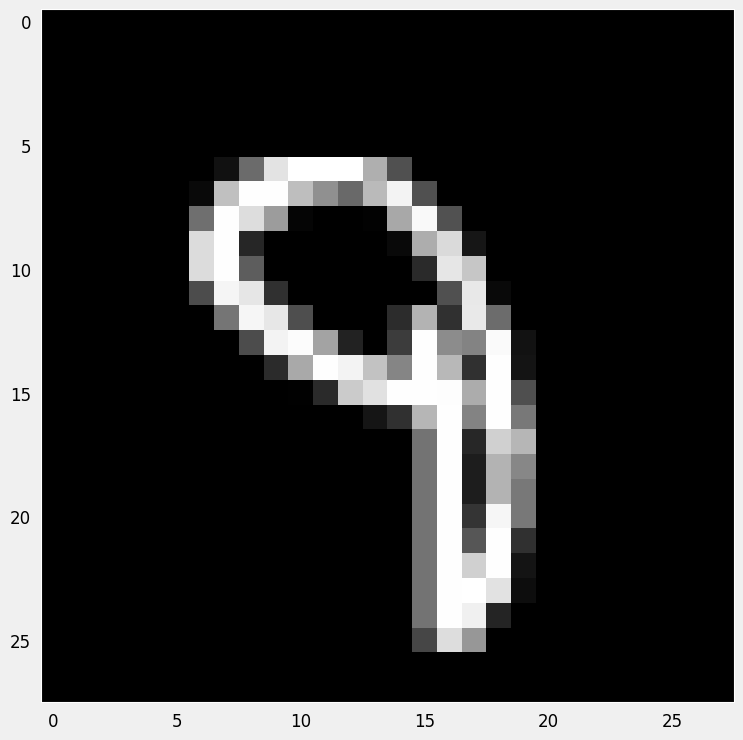

[9.8263896e-01 8.6963653e-10 2.2888146e-04 1.5500208e-03 2.3273537e-06
 1.2791399e-02 1.9991287e-06 2.4872751e-04 2.2396122e-03 2.9814127e-04]
[1.5393810e-04 1.9443490e-02 1.1143621e-01 2.4810778e-01 1.9432733e-02
 2.5916663e-01 1.6015070e-02 2.4451034e-03 2.8204823e-01 4.1750897e-02]
3


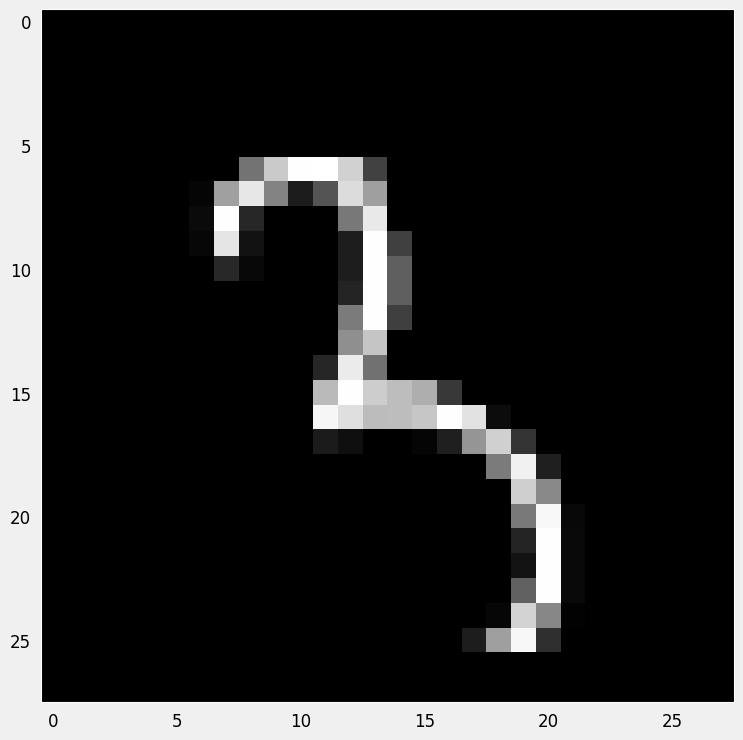

[1.4219287e-06 9.7820801e-01 9.5688237e-04 1.0011052e-03 6.7059600e-06
 5.1070558e-04 2.1401448e-03 2.3485678e-05 1.6802892e-02 3.4861817e-04]
[1.7618733e-05 7.8554064e-07 2.0219552e-04 4.8850927e-07 3.3724587e-05
 1.2750317e-04 9.9940765e-01 2.2238376e-09 2.0823680e-04 1.8300633e-06]
[4.8839873e-05 6.7068581e-06 5.6630449e-04 4.5154598e-03 8.8129783e-01
 1.0823016e-02 3.5647623e-04 1.2689229e-02 1.9062491e-02 7.0633613e-02]
[1.4653193e-05 9.4549860e-06 9.9120164e-01 6.8509011e-03 5.4880289e-08
 3.1632294e-06 9.3843782e-06 5.5830460e-06 1.8978264e-03 7.3521473e-06]
[6.1385486e-05 1.3361250e-09 2.2026988e-02 9.7668648e-01 1.7242364e-09
 1.1467369e-03 3.6894940e-07 3.0847374e-09 7.7967350e-05 4.2371052e-08]
[1.1628305e-03 2.1394444e-08 1.2609591e-03 8.9491783e-07 1.0524080e-05
 3.3916299e-07 9.9752611e-01 4.0990399e-06 3.0988500e-05 3.2275025e-06]
[1.8291334e-04 9.3425143e-01 2.5804464e-02 8.7935952e-03 5.2614347e-04
 6.3330372e-04 6.0898735e-04 2.3444053e-03 2.5752885e-02 1.1019404e-03]

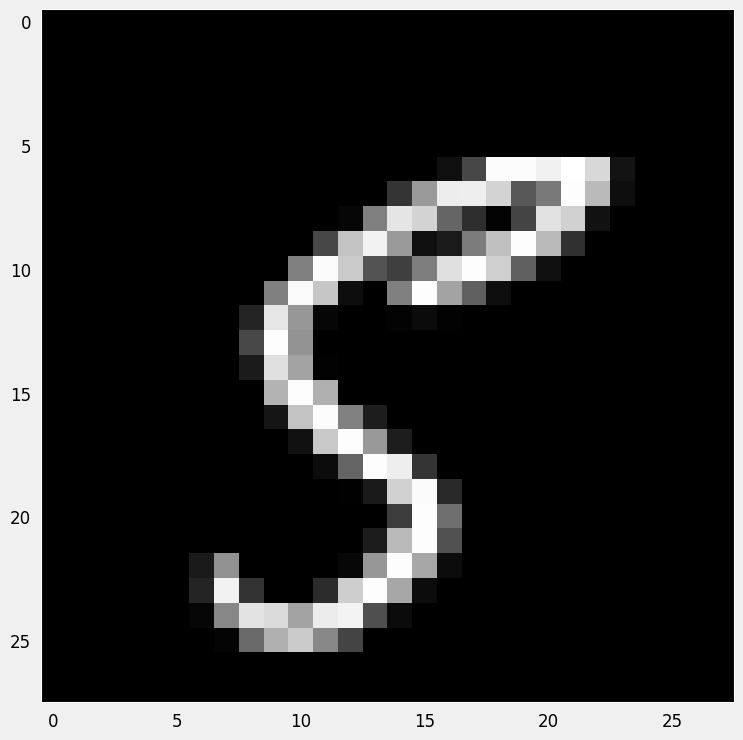

[2.6874318e-07 2.5362015e-05 6.9701033e-05 4.8865546e-03 1.5578618e-02
 3.8506167e-03 3.0379060e-05 3.7532351e-03 1.2333624e-03 9.7057188e-01]
[1.08875975e-04 2.89797969e-02 1.59577411e-02 8.47058952e-01
 1.64891395e-03 4.01057117e-03 1.71903215e-04 6.34242361e-03
 2.31837090e-02 7.25371018e-02]
[1.3944721e-06 2.6460424e-05 2.0372862e-04 5.4588425e-03 6.1062299e-02
 1.5305432e-03 2.3731120e-05 5.2916585e-03 1.3857463e-02 9.1254395e-01]
[9.7870380e-01 5.1929798e-09 3.9958004e-03 8.2024554e-04 3.7722764e-04
 6.8216617e-03 1.6167705e-04 6.7079574e-04 5.9068436e-03 2.5420904e-03]
[1.7152184e-05 1.9042785e-05 1.4638925e-03 9.9510044e-01 2.7190679e-05
 2.8304115e-04 3.4041823e-06 2.4719682e-04 9.9050731e-04 1.8480696e-03]
[1.2570006e-02 1.8177620e-03 1.2099728e-03 1.9026714e-04 4.6005412e-03
 3.9941978e-01 5.4781681e-01 6.5517514e-07 3.2354899e-02 1.9347632e-05]
[6.8921060e-03 2.9920047e-04 3.0518140e-04 1.3799512e-02 3.5280683e-03
 6.5436053e-01 5.7984184e-05 2.7849880e-01 3.8975846e-02 3.2

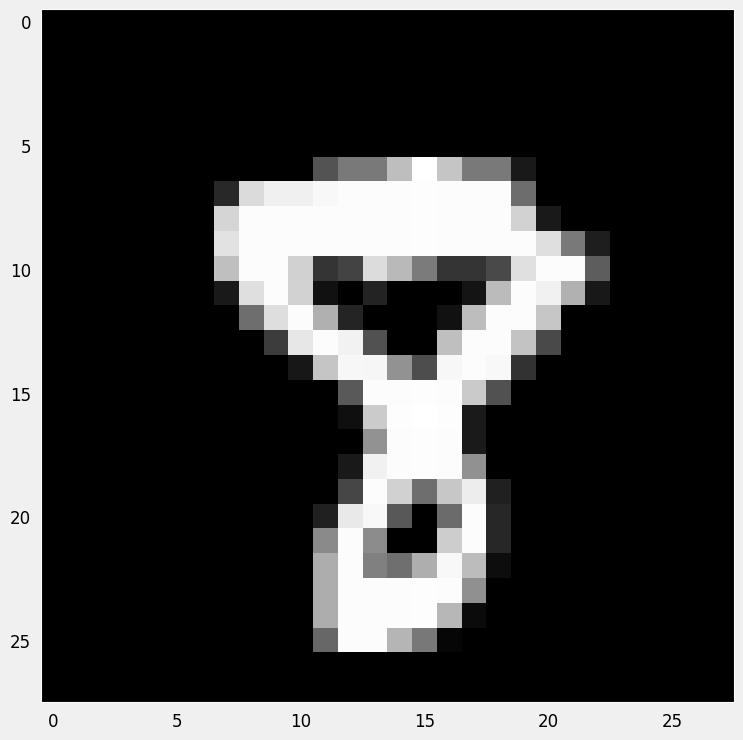

[2.7368552e-04 1.2808167e-04 4.3809232e-03 8.1650332e-02 4.1613230e-04
 1.1161194e-03 4.3447417e-05 8.3296025e-01 5.3468714e-03 7.3684178e-02]
[1.2463459e-03 9.5816258e-06 2.2730986e-03 6.3017220e-04 6.9387169e-03
 1.1258352e-03 3.9284027e-04 3.8215068e-01 1.5097478e-03 6.0372299e-01]
[2.3724376e-06 2.4932920e-05 9.8419869e-01 1.4864386e-02 3.9413358e-06
 1.7009966e-06 8.6249650e-04 5.9202753e-06 2.5866442e-05 9.6518588e-06]
[9.3541184e-06 7.9713482e-03 9.6763259e-01 1.0111426e-03 4.7347188e-05
 8.7572298e-06 2.2061568e-02 4.9511723e-06 1.2249689e-03 2.7983902e-05]
[2.0629832e-06 1.0620820e-07 2.9410071e-06 9.9185422e-07 9.9319941e-01
 1.9593947e-06 2.1305957e-04 3.5982208e-05 1.4588020e-04 6.3976054e-03]
[3.7997061e-06 9.9331254e-01 2.3747905e-04 3.5914856e-03 2.0682093e-05
 3.6369704e-04 2.7088233e-04 3.9142885e-04 1.1977922e-03 6.1022158e-04]
[1.0192789e-03 4.4645931e-05 1.6938375e-03 3.7916366e-02 1.7014757e-04
 6.9052303e-01 1.4687572e-03 6.1129873e-07 2.6671538e-01 4.4791997e-04]

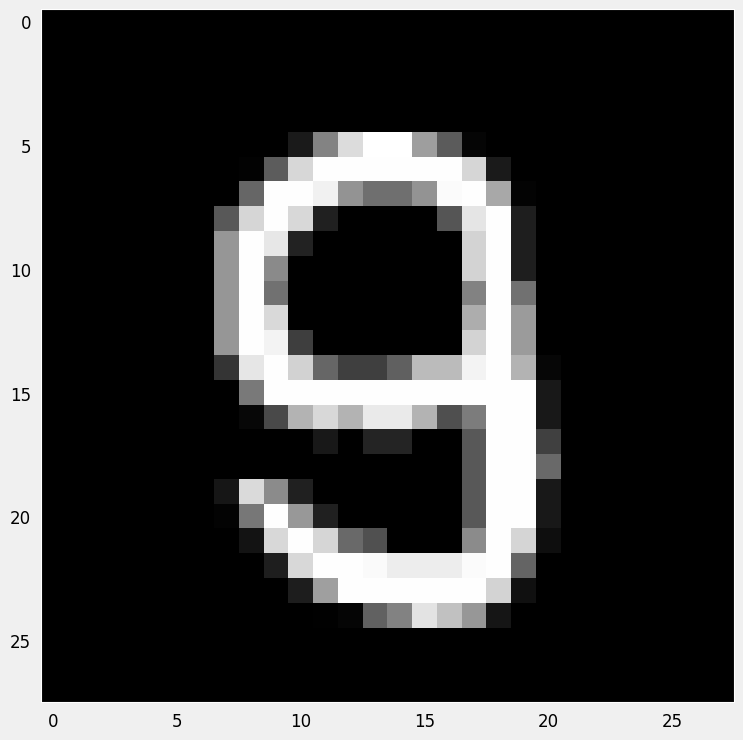

[1.01157110e-02 1.75989143e-07 1.05329533e-03 6.69454585e-06
 1.07922155e-04 4.13669244e-04 7.00419187e-04 2.32821258e-04
 9.06783819e-01 8.05854574e-02]
[3.5088728e-05 7.2602576e-05 1.2230894e-02 5.6856375e-02 9.7368591e-02
 2.9443987e-04 2.6807371e-03 8.1493700e-01 2.0064355e-03 1.3517794e-02]
[4.0186744e-04 4.1084915e-02 8.0523103e-01 1.1868296e-01 4.4980459e-04
 1.2048478e-03 3.4292492e-03 1.7352084e-02 5.8718584e-03 6.2914016e-03]
[2.4408707e-02 4.0639649e-04 6.6705099e-03 3.2459909e-01 1.9013998e-03
 2.0923655e-01 4.2302945e-01 1.6083160e-03 7.6932958e-03 4.4635753e-04]
3


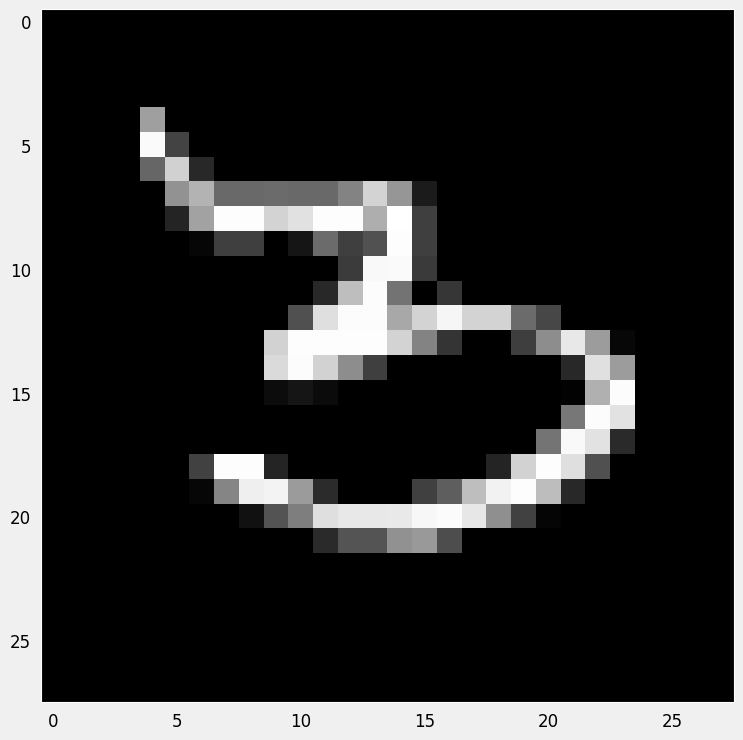

[9.9486262e-01 7.8399023e-11 4.4011609e-03 2.0744189e-06 3.6940112e-10
 1.4799275e-05 3.0039137e-05 8.6622629e-09 6.8929431e-04 3.2591907e-09]
[1.6382917e-04 1.9946652e-03 3.3466434e-01 1.2398694e-01 7.2485074e-02
 2.3564533e-03 3.7055707e-01 1.7292197e-04 3.4824003e-02 5.8794659e-02]
4


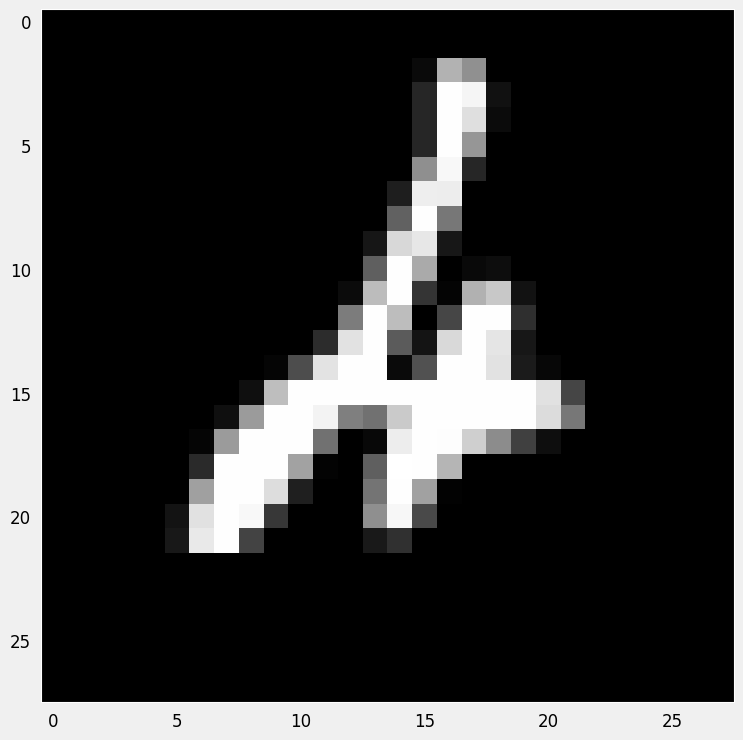

[1.25794213e-05 7.23264915e-09 5.00688429e-06 1.15412135e-07
 9.97699440e-01 1.45834599e-06 1.03529150e-04 1.78638889e-04
 6.88630505e-04 1.31049403e-03]
[1.8043812e-04 1.2586072e-01 8.3204865e-01 9.0318145e-03 5.7921088e-06
 1.4986876e-04 2.9084006e-02 1.3323789e-05 3.6218832e-03 3.4805407e-06]
[3.2165980e-07 2.1507938e-06 2.1506286e-05 4.3667411e-04 8.9652538e-01
 5.7798001e-04 2.1909997e-05 8.3636623e-05 2.8262150e-03 9.9504165e-02]
[0.00096818 0.6565521  0.01011134 0.03635322 0.00151344 0.15272231
 0.01107877 0.00336072 0.11225034 0.01508954]
[1.4169906e-07 7.2416360e-06 1.1843956e-06 2.1875067e-05 1.8356396e-02
 3.9733932e-05 1.7418266e-05 1.9948613e-03 5.1811372e-04 9.7904301e-01]
[4.7645578e-03 6.0308448e-05 2.9389680e-04 4.3030094e-02 1.4133649e-03
 9.2437035e-01 4.0606872e-04 4.7426158e-05 2.3655698e-02 1.9582994e-03]
[2.1630474e-05 3.0790048e-07 4.9994275e-04 1.7000435e-02 1.4943123e-05
 3.7823786e-05 5.1869614e-07 9.7588432e-01 1.9035370e-04 6.3497033e-03]
[1.35153678e-05 1.

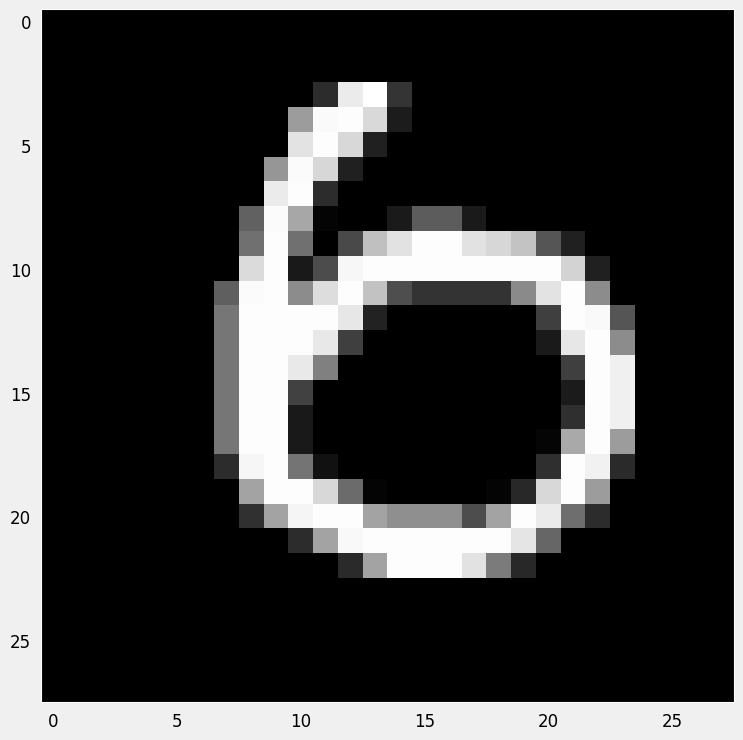

[2.5432778e-03 7.5742405e-06 1.0936274e-03 3.3226381e-05 2.2430233e-04
 2.6990429e-02 4.7480706e-05 1.5971347e-05 9.6747464e-01 1.5694671e-03]
[1.0862569e-02 1.3295737e-01 2.2261677e-02 8.8088073e-02 1.1098649e-05
 6.2140840e-01 3.8630809e-05 2.1176159e-02 1.0094819e-01 2.2477745e-03]
[4.2883505e-07 6.9636889e-07 2.1424923e-05 7.7207293e-04 2.7505357e-06
 1.0617678e-06 2.0029281e-08 9.9906188e-01 5.6943745e-06 1.3384652e-04]
[4.2855484e-07 1.3088296e-05 7.0950613e-05 9.0225833e-04 9.4345123e-06
 2.3573204e-05 5.1765016e-07 9.8687881e-01 1.4125281e-04 1.1959782e-02]
[1.3212928e-05 1.1530880e-01 7.3553049e-03 1.6754276e-01 3.7565004e-02
 6.9854170e-02 4.0144264e-04 2.1368058e-03 9.6654698e-02 5.0316787e-01]
[2.7913123e-07 9.9555945e-01 4.2613200e-04 1.8162050e-03 1.6766252e-06
 5.7412097e-05 1.5050515e-04 1.2588956e-05 1.8737573e-03 1.0198324e-04]
[9.2042878e-02 8.1572434e-06 1.1335704e-03 8.2218768e-03 1.9419902e-04
 1.1553097e-01 1.0369858e-02 4.6971500e-06 7.6979500e-01 2.6988091e-03]

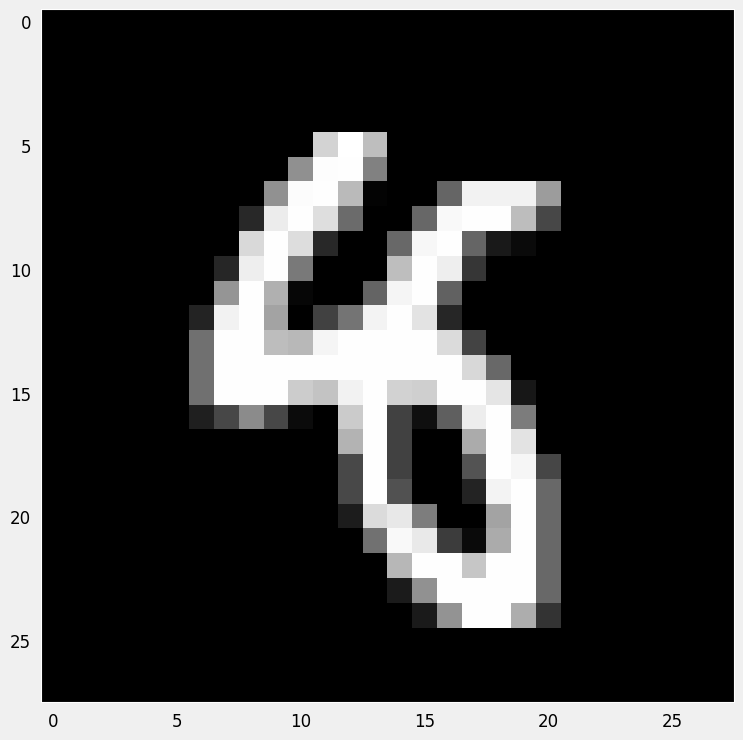

[8.4411735e-03 9.1848144e-04 7.2028702e-01 2.0764370e-01 6.0092901e-08
 4.7301080e-02 2.6056732e-03 9.8998132e-10 1.2802818e-02 5.7509496e-08]
[2.2166746e-06 1.3534233e-06 3.0205798e-04 1.6475040e-05 3.4410693e-03
 5.1042916e-05 1.0954040e-05 2.5921214e-02 5.7456479e-04 9.6967906e-01]
[4.3698941e-07 8.8449917e-04 9.9682021e-01 1.5294905e-04 2.1317435e-04
 2.8240430e-07 1.4043134e-03 1.5183006e-07 2.0781459e-04 3.1613355e-04]
[9.6736151e-01 2.9068746e-08 1.4763694e-03 9.1707113e-04 1.4600425e-06
 2.5255488e-02 3.4638740e-06 3.9693277e-05 4.5100795e-03 4.3478448e-04]
[8.41859946e-06 2.06326513e-06 2.31599715e-05 2.55034026e-03
 8.87103260e-01 5.33101906e-04 6.61860977e-05 3.67802932e-05
 8.79430270e-04 1.08797185e-01]
[9.9962318e-01 9.3722458e-13 2.3377679e-05 1.4023739e-05 4.1481076e-11
 3.3774172e-04 9.4774315e-08 2.7619695e-08 1.5929280e-06 5.9822196e-09]
[9.8642272e-01 3.3928653e-09 7.3699036e-04 2.9316428e-04 1.0839890e-08
 1.2030796e-02 2.8741668e-04 9.9003031e-05 1.2903345e-04 8.0

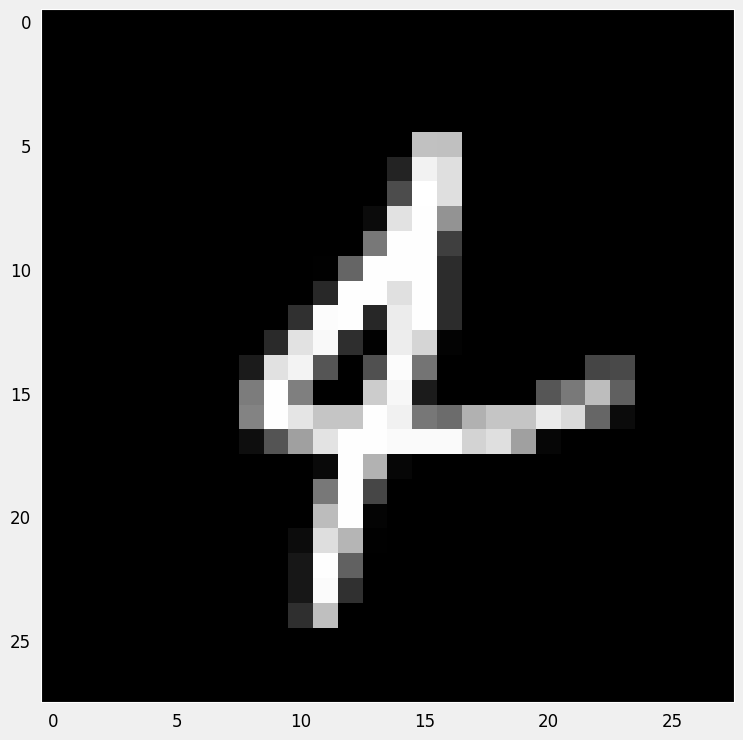

[1.9441595e-06 2.7965651e-05 3.5267949e-02 3.4066215e-03 1.9775801e-03
 2.2841317e-05 3.8851390e-04 9.5405352e-01 7.2654727e-04 4.1264584e-03]
[5.3038247e-07 9.9705029e-01 2.4395407e-04 1.0305878e-03 9.7099273e-06
 1.4705278e-04 2.2338009e-04 3.8164508e-05 1.1025262e-03 1.5383965e-04]
[1.0242447e-03 3.2633153e-04 8.3004940e-01 1.0023264e-02 3.1457085e-03
 7.6426059e-04 1.2563180e-02 7.9381324e-02 2.8929722e-02 3.3792663e-02]
[8.5586680e-06 2.8543247e-04 4.2324906e-04 3.2612169e-03 7.0427173e-01
 5.8863186e-03 1.1859756e-03 2.8484745e-02 7.2787546e-02 1.8340522e-01]
[7.0983714e-01 2.7678628e-09 3.7183229e-02 3.0973421e-05 2.3655479e-08
 2.2305842e-01 2.8422551e-06 7.5286728e-08 2.9887281e-02 5.6967746e-09]
[4.4362860e-05 1.4952717e-02 9.5858973e-01 2.1795694e-02 1.5068194e-08
 3.0693347e-05 1.2367786e-03 1.7471386e-07 3.3482022e-03 1.7143863e-06]
[4.3863383e-05 2.2636610e-03 9.3027398e-02 8.8001071e-03 1.1655646e-02
 3.2748288e-04 9.7993854e-04 3.3285207e-01 7.3265672e-02 4.7678414e-01]

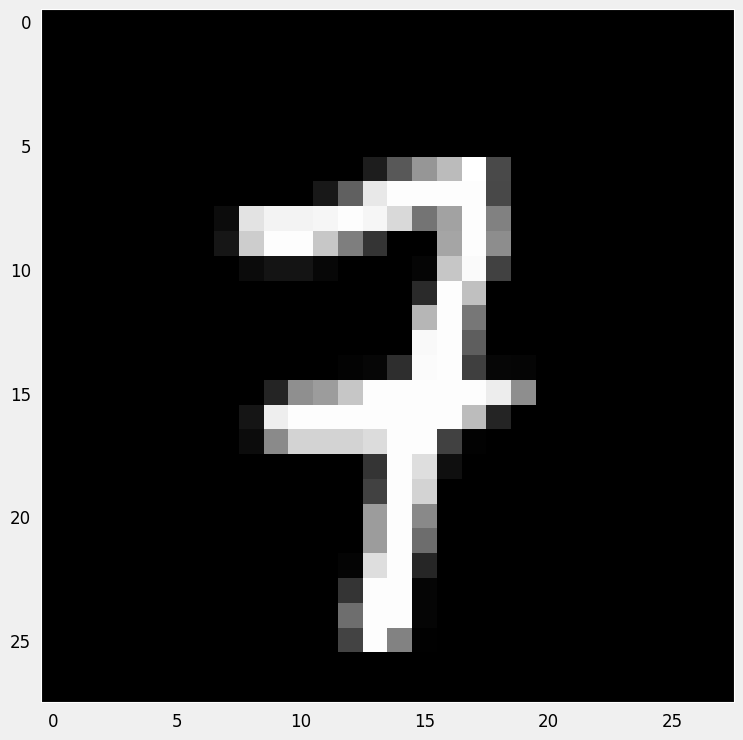

[1.3995120e-06 2.1775436e-06 2.0544509e-05 5.5408609e-06 9.8003221e-01
 1.0835177e-04 1.7724035e-04 4.1575803e-04 1.7749323e-02 1.4874837e-03]
[1.3070029e-03 1.0345887e-03 1.2174181e-02 9.7071260e-01 9.6933363e-06
 8.5741878e-03 5.5354356e-04 6.8596823e-06 5.5692266e-03 5.8172111e-05]
[7.2039501e-04 1.0900248e-03 9.1561666e-03 9.2584270e-01 5.1200320e-04
 2.8429139e-02 5.3579238e-04 2.5388877e-05 3.3118140e-02 5.7023438e-04]
[9.9988866e-01 1.4331877e-14 7.8309822e-05 5.7766570e-08 1.8285289e-10
 7.9978867e-07 2.3601073e-05 1.4214471e-09 8.6307109e-06 2.1961952e-09]
[9.9832350e-01 3.7573864e-11 1.4194341e-04 1.5652479e-06 4.3656482e-06
 3.3120567e-04 9.6413877e-04 5.1868557e-07 2.1715302e-04 1.5461472e-05]
[4.1090413e-03 1.7253467e-05 5.3738961e-03 4.0212137e-01 1.8243387e-02
 5.4371202e-01 4.2002145e-03 2.4042869e-05 2.2032730e-02 1.6590906e-04]
3


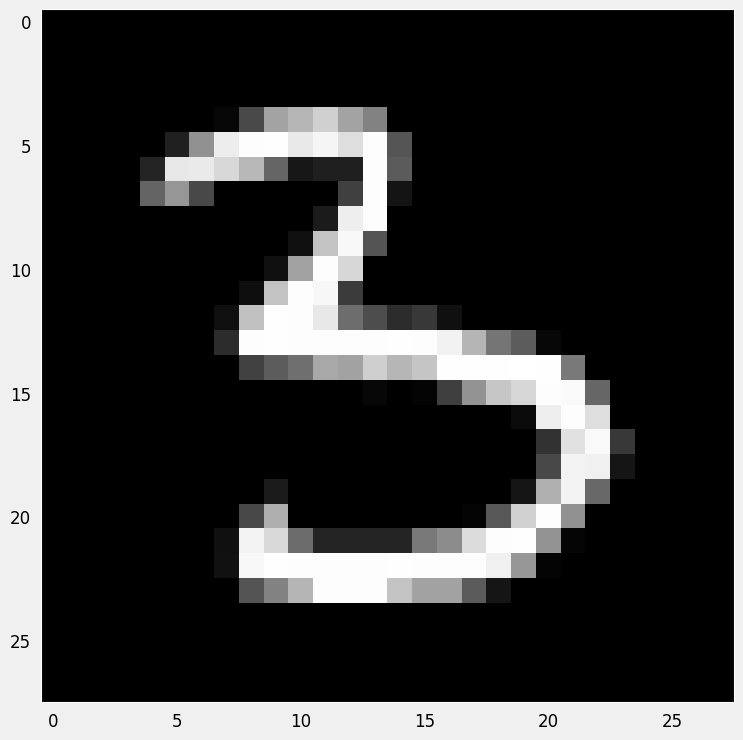

[6.8700888e-07 9.9408686e-01 2.5328284e-04 2.8380717e-03 9.4242323e-06
 2.2630348e-04 2.1865791e-04 3.4764853e-05 2.1660628e-03 1.6590051e-04]
[6.4352754e-04 1.4933254e-07 2.2943222e-03 5.9140282e-05 5.5225180e-03
 1.4336785e-05 2.7399679e-04 5.8982719e-02 4.8042443e-02 8.8416684e-01]
[8.8159213e-05 9.5596413e-05 1.2759505e-05 4.9564192e-06 2.3610660e-04
 2.0129303e-03 9.9671102e-01 3.3217262e-08 8.2650414e-04 1.1977635e-05]
[5.8194106e-05 1.5948669e-03 4.2014117e-06 9.1578033e-05 4.7316782e-02
 8.6662102e-01 1.4611445e-03 3.7182422e-04 8.2054056e-02 4.2634859e-04]
[8.0612846e-02 2.3682348e-07 2.7533916e-01 6.2266648e-01 4.5782272e-04
 4.3626275e-04 7.2264224e-03 2.4209371e-07 1.3255419e-02 5.0730555e-06]
2


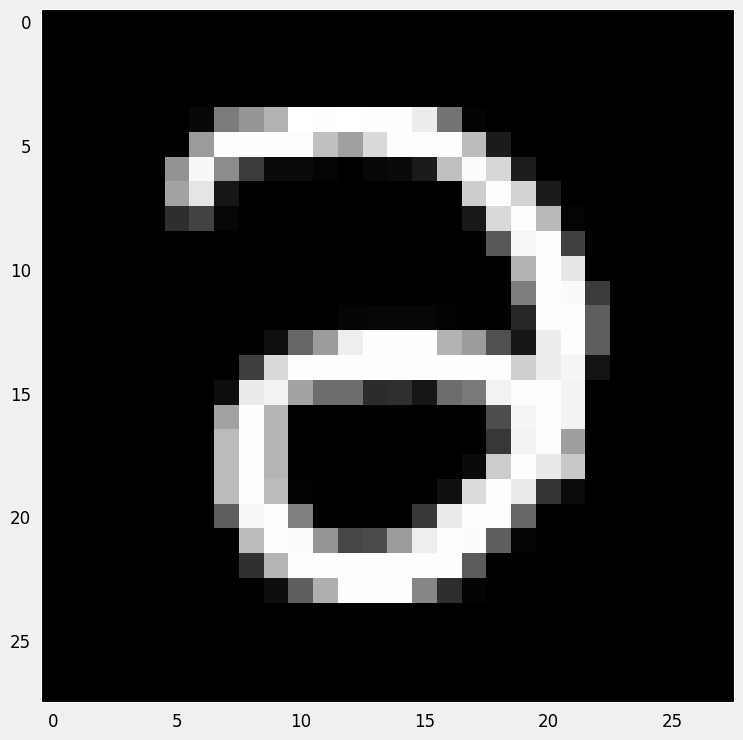

[3.2299906e-03 2.5981203e-06 7.1525283e-04 2.3166295e-03 1.5367069e-03
 9.5395660e-01 3.9083092e-03 1.3717884e-08 3.4326866e-02 7.0138144e-06]
[2.07996054e-05 1.96088925e-01 4.66657017e-04 2.53814068e-02
 1.11601046e-04 4.69043618e-03 7.19304371e-05 6.98732674e-01
 3.06670461e-02 4.37683873e-02]
9


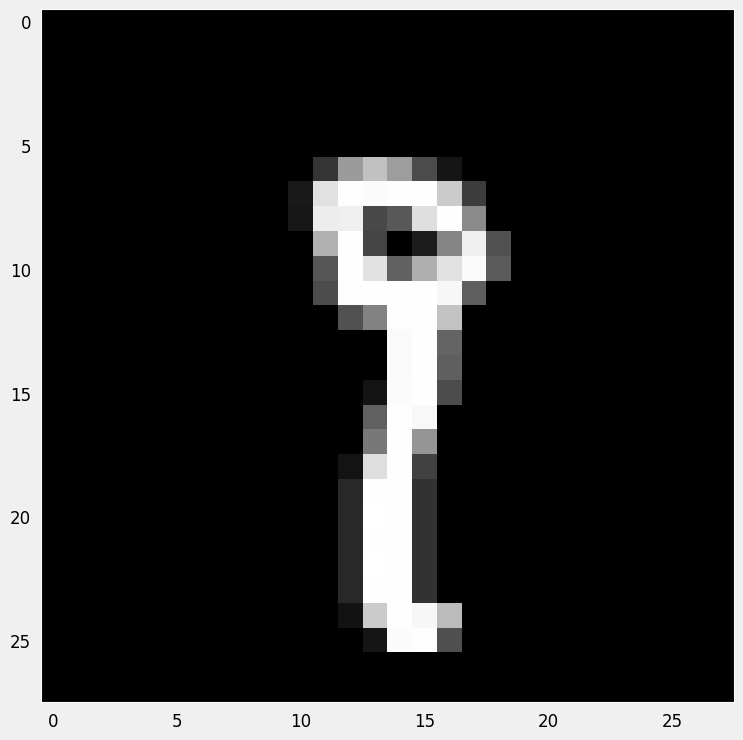

[2.1645142e-04 2.9038913e-03 2.8023290e-02 8.3754629e-02 7.1594557e-05
 2.7805269e-03 2.0655329e-05 8.1499338e-01 4.1811585e-02 2.5424013e-02]
2


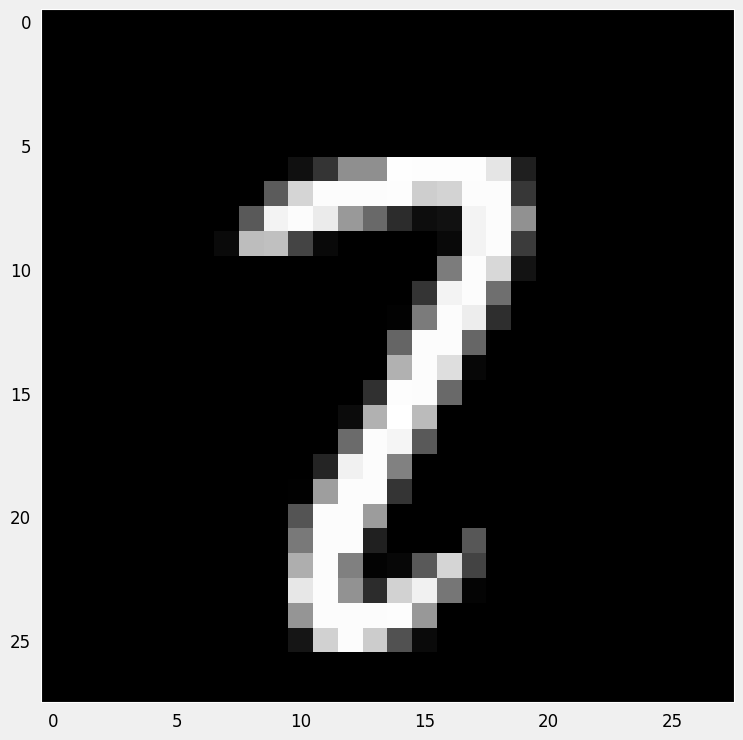

[2.1119777e-06 1.7931183e-04 9.9931358e-06 1.0290539e-02 7.9962583e-03
 4.4041327e-03 1.4785639e-05 9.6339798e-03 2.8899803e-03 9.6457893e-01]
[1.1280841e-03 3.9238101e-03 2.9843459e-03 9.5362055e-01 7.4139243e-05
 5.8312975e-03 8.7308363e-06 9.0750276e-05 3.2175601e-02 1.6278490e-04]
[0.63445014 0.00135592 0.08344656 0.04091307 0.00354733 0.07915592
 0.00655688 0.02461549 0.02321466 0.10274404]
[5.6769297e-04 5.7388675e-05 1.1887264e-02 3.2535943e-04 5.0466317e-01
 2.6500458e-03 2.5716001e-02 6.6144643e-03 1.3643998e-01 3.1107855e-01]
[3.7932250e-04 1.8192865e-03 9.4116980e-01 3.6856683e-03 4.3493515e-08
 6.1085881e-03 3.7725285e-02 2.1385669e-09 9.1001075e-03 1.1887831e-05]
[9.9645185e-01 2.0848052e-11 1.9844336e-05 1.3134787e-06 2.4640294e-06
 2.9901024e-03 2.9659603e-04 3.0652518e-07 2.3623707e-04 1.2671669e-06]
[5.9172198e-06 1.0805707e-03 7.8302604e-04 1.0405145e-04 7.8839177e-05
 1.0174623e-04 1.6135818e-05 9.7921306e-01 6.1871083e-03 1.2429587e-02]
[3.39043936e-07 9.93475854e-0

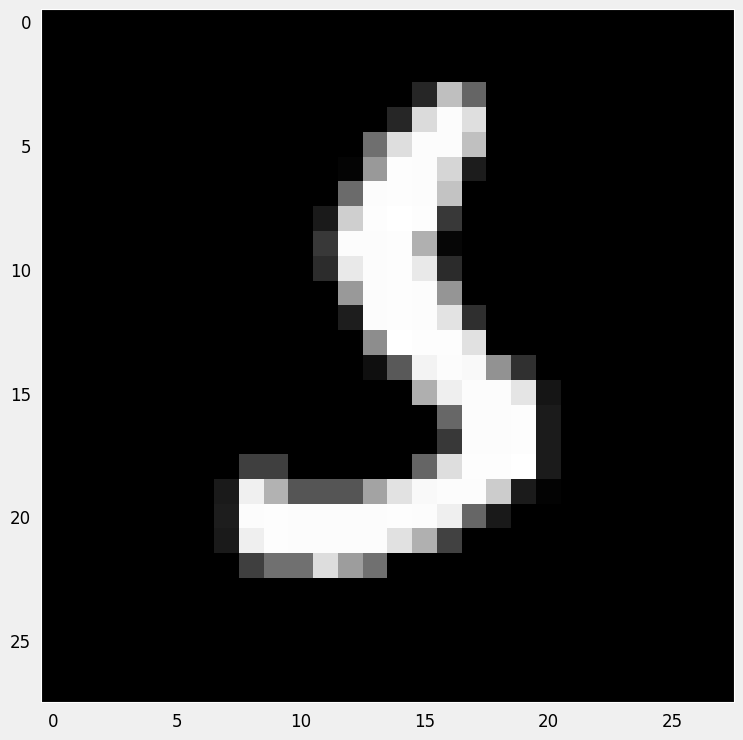

[0.00222073 0.00184255 0.06068786 0.04303117 0.34494892 0.00495738
 0.40538573 0.07373152 0.01407747 0.04911667]
[4.4848639e-06 9.8801672e-01 4.7674138e-04 3.8941347e-03 7.8287039e-06
 5.2192016e-04 1.9921118e-04 2.9442625e-04 5.6611951e-03 9.2334679e-04]
[1.5776379e-02 1.0567645e-04 2.5691860e-04 9.1456056e-01 1.6795851e-06
 6.6033736e-02 2.9361233e-06 2.7964124e-06 3.2506420e-03 8.7297221e-06]
[3.4054008e-04 1.6842883e-03 3.2529815e-03 1.1650941e-02 3.4677229e-04
 2.6599881e-01 2.5310276e-02 5.4883540e-06 6.9067144e-01 7.3842186e-04]
[2.4465615e-07 9.8975068e-01 2.6669598e-04 5.5724178e-03 9.1685442e-06
 6.2043779e-05 4.3774107e-05 2.1967373e-04 2.3605779e-03 1.7147623e-03]
[9.8322958e-01 7.8417436e-08 8.8144996e-04 5.2919914e-03 2.7513070e-06
 2.7106637e-03 5.5632310e-05 5.0830422e-05 6.4542550e-03 1.3229089e-03]
[1.3179044e-04 7.9453617e-05 4.2487250e-06 6.1770414e-05 6.9741346e-04
 9.6947461e-01 9.7606120e-05 3.1045943e-06 2.9402681e-02 4.7469450e-05]
[3.1469386e-05 9.7753644e-01 

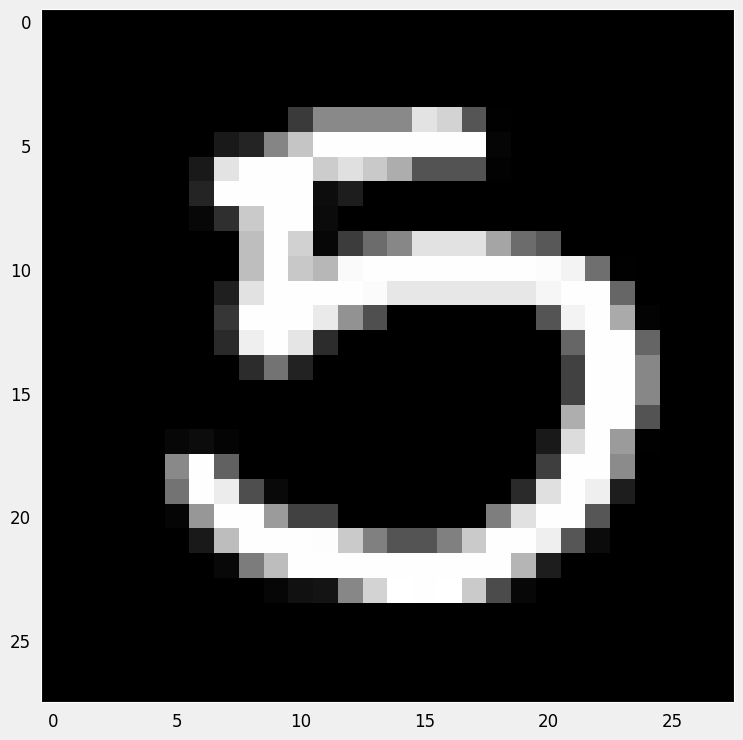

[2.4672691e-04 9.2680700e-08 1.2537734e-02 6.4402434e-06 3.7287052e-03
 1.3266723e-05 9.6945101e-01 8.9506148e-06 9.4855642e-03 4.5216144e-03]
[4.0930058e-04 8.8518649e-01 5.0436754e-02 7.6556369e-03 2.4605999e-03
 5.8834907e-04 2.9440455e-03 1.2283949e-03 4.7810920e-02 1.2793724e-03]
[1.4783499e-03 1.6377113e-03 1.0745290e-03 3.2915271e-04 2.5316633e-04
 5.7788128e-03 7.7992626e-03 2.3971227e-06 9.7927397e-01 2.3725589e-03]
[6.0987665e-04 2.9484633e-07 2.8569204e-07 5.1753465e-03 1.0724876e-04
 9.8965341e-01 3.2816929e-06 1.0992782e-05 3.3643590e-03 1.0749329e-03]
[0.00325386 0.76222205 0.01565458 0.09195788 0.00151297 0.01461261
 0.00874985 0.04470547 0.02565458 0.03167612]
[4.1051164e-05 8.5595064e-03 1.3088141e-04 4.3416206e-02 1.6126687e-02
 4.8766527e-03 5.1494408e-05 5.3581423e-01 4.2974073e-02 3.4800920e-01]
[3.5290428e-05 1.7525555e-04 2.9629172e-04 1.6757254e-03 5.5249631e-01
 2.4486147e-03 3.8525919e-04 3.2765118e-03 4.2309418e-02 3.9690134e-01]
9


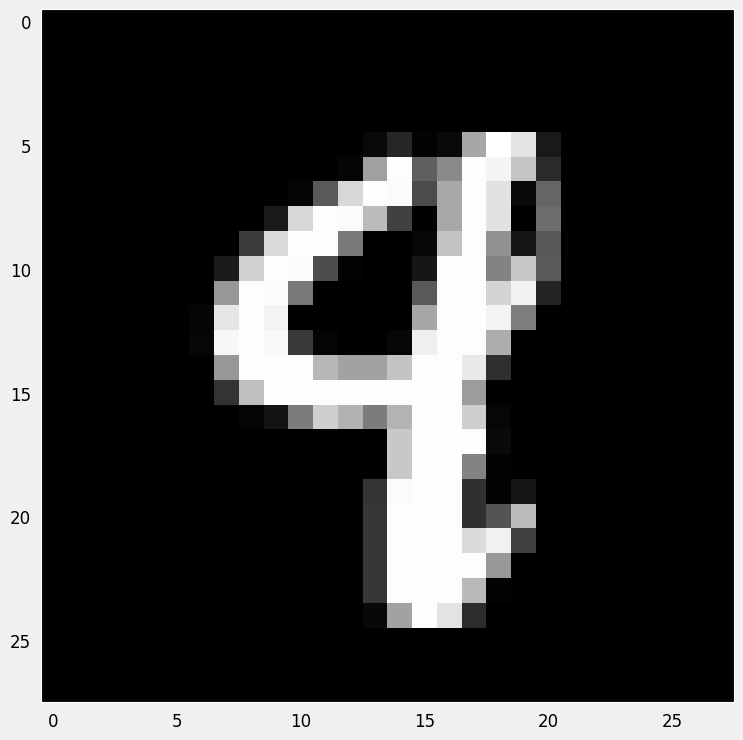

[8.7791768e-06 1.4747768e-07 9.2662859e-04 3.3725721e-03 9.9330056e-01
 9.2208775e-06 1.0913117e-03 1.9243259e-04 3.6626245e-04 7.3211524e-04]
[3.9234778e-06 9.1746318e-07 1.4495564e-03 1.9272404e-05 2.2328466e-03
 3.9530114e-05 9.9552578e-01 1.3372252e-06 4.5063271e-04 2.7630239e-04]
[1.4581506e-03 1.7984603e-06 7.0859186e-02 1.6946578e-01 4.5092200e-04
 5.0017965e-04 8.1474036e-07 6.9242334e-01 6.0718507e-02 4.1212873e-03]
2


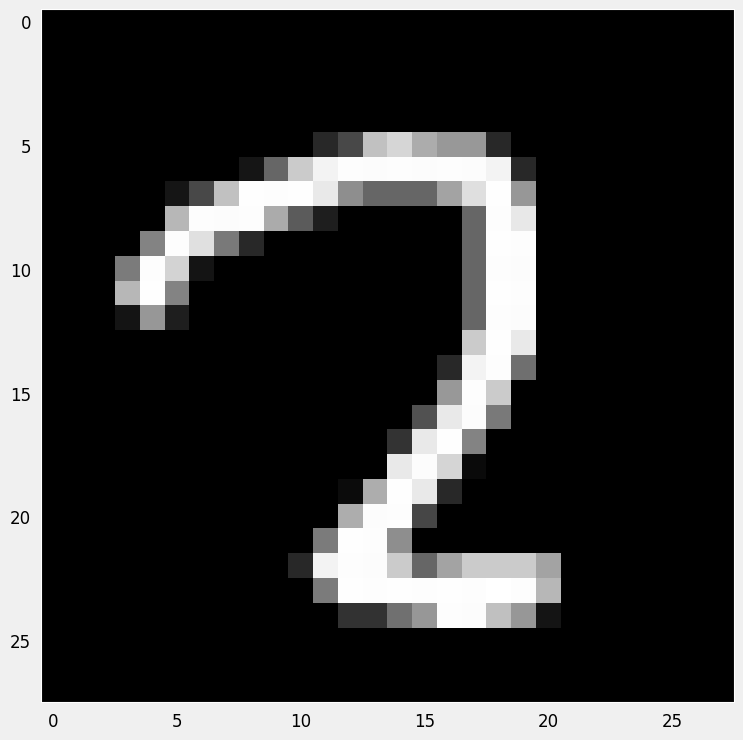

[1.5180221e-05 6.7210168e-02 8.6040872e-01 2.6885517e-02 2.1217513e-08
 1.8743223e-04 4.4730429e-02 3.7596369e-08 5.6216691e-04 4.6741920e-07]
[2.2936903e-02 1.0225384e-05 5.3948243e-03 5.2101887e-03 8.7934808e-04
 7.3287016e-01 1.3681765e-04 2.3164555e-05 2.2986698e-01 2.6713395e-03]
[9.5996094e-01 7.5688583e-08 6.3594594e-04 4.4852050e-04 9.1757305e-05
 3.2354157e-02 4.0916514e-04 2.4734823e-05 5.7377312e-03 3.3684444e-04]
[0.00787319 0.01027452 0.0649739  0.00335917 0.00751541 0.00492462
 0.86913943 0.00646588 0.02106302 0.00441077]
[4.7991815e-04 1.0620928e-06 4.7589196e-03 1.6293095e-02 8.3920769e-03
 8.7144709e-01 2.7340817e-05 5.5180558e-06 9.6906945e-02 1.6880211e-03]
[4.4236152e-04 8.0549995e-05 3.4866352e-02 6.0389057e-04 1.2997916e-03
 1.1960233e-02 9.3711466e-01 1.1149777e-06 1.3348541e-02 2.8251891e-04]
[3.1843949e-03 2.1187583e-05 2.2013234e-04 9.6882766e-01 1.2219758e-04
 1.9904975e-02 4.8789702e-06 1.0643875e-03 5.3089550e-03 1.3412443e-03]
[2.1346412e-07 7.5808612e-07 

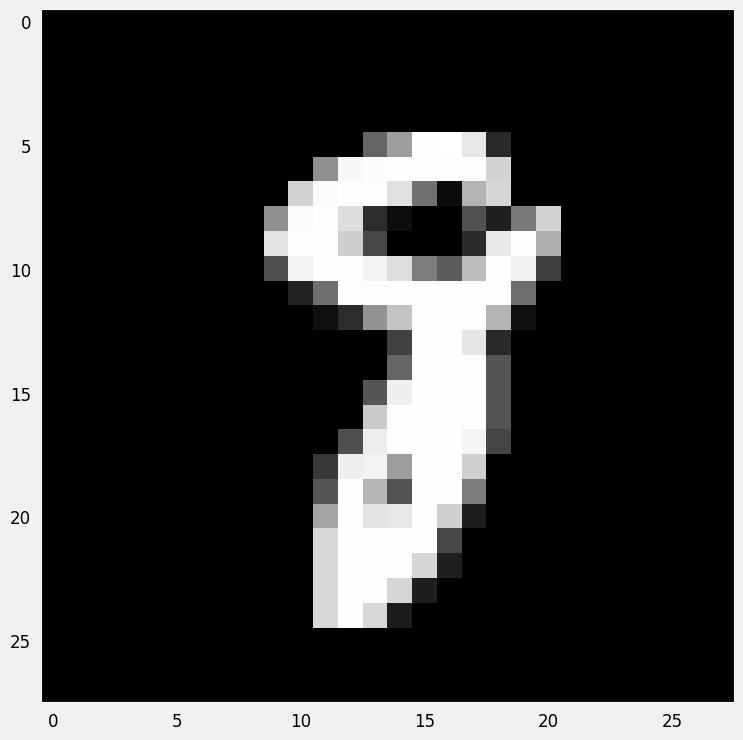

[6.2261173e-03 1.9964098e-04 2.3477366e-02 2.3707058e-03 7.0430553e-03
 1.4211251e-01 1.9283888e-03 8.0841994e-03 7.9670066e-01 1.1857329e-02]
[3.9834586e-07 2.2473596e-09 4.7651582e-05 9.9821967e-01 6.1570375e-08
 1.2129542e-03 1.6800215e-10 5.9337822e-08 5.1923218e-04 3.8670969e-08]
[1.3015998e-04 3.1020934e-07 2.3332041e-05 3.9475987e-04 1.8002078e-05
 2.3156352e-04 1.0898240e-06 9.1873801e-01 2.7280167e-04 8.0190018e-02]
[2.7078497e-03 1.4304408e-05 1.9408511e-04 1.1271496e-03 2.5458268e-03
 3.4108672e-02 9.5303863e-01 5.4268512e-06 4.9181795e-03 1.3398719e-03]
[9.9999440e-01 1.2106766e-15 5.0449108e-07 6.8378438e-07 2.3351843e-12
 3.2062346e-06 2.9936917e-09 4.2212389e-07 7.7872795e-07 1.9819579e-09]
[9.9634200e-01 2.9195926e-09 2.7570027e-04 5.5790852e-06 6.2738941e-06
 6.7784271e-04 1.9935600e-03 3.5737719e-06 6.3275197e-04 6.2722400e-05]
[4.5534748e-06 4.5974076e-07 1.2450532e-05 9.8439664e-01 7.4149666e-06
 1.4650453e-02 6.8861527e-06 6.8383006e-06 7.2148541e-04 1.9277776e-04]

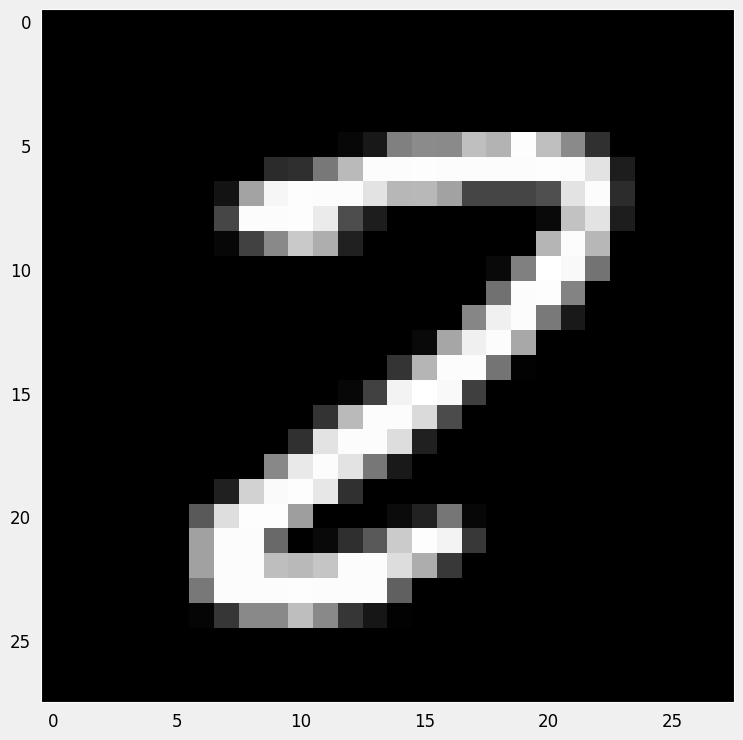

[9.6454418e-01 2.4443563e-07 6.2039716e-04 2.4231389e-04 2.3982479e-04
 1.8871832e-03 1.2796658e-02 1.8822327e-02 5.3963612e-04 3.0722888e-04]
6


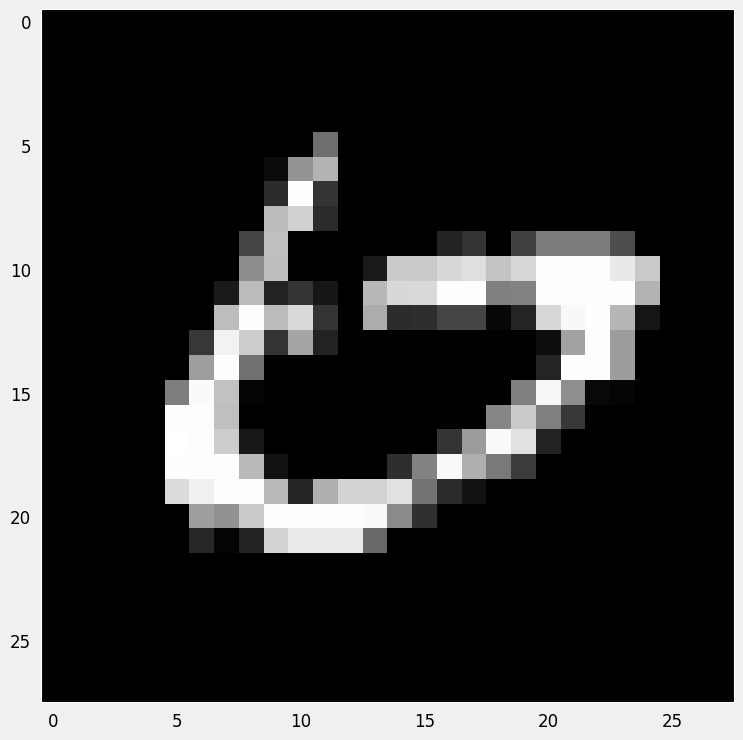

[4.94486943e-04 5.86200576e-06 2.14359583e-03 1.15419614e-04
 1.61102653e-04 2.15595122e-03 9.75616574e-01 1.91770599e-08
 1.86279863e-02 6.79082412e-04]
[5.7679812e-05 1.0110406e-04 1.8094119e-04 1.0472886e-03 7.5357342e-01
 3.9345923e-05 1.9931605e-04 9.1969641e-04 1.2851985e-02 2.3102929e-01]
[3.7798167e-03 1.6712416e-05 1.4106685e-03 8.1444070e-02 9.8030986e-03
 1.2299033e-01 2.1895261e-04 7.3053694e-04 6.0320139e-01 1.7640442e-01]
9


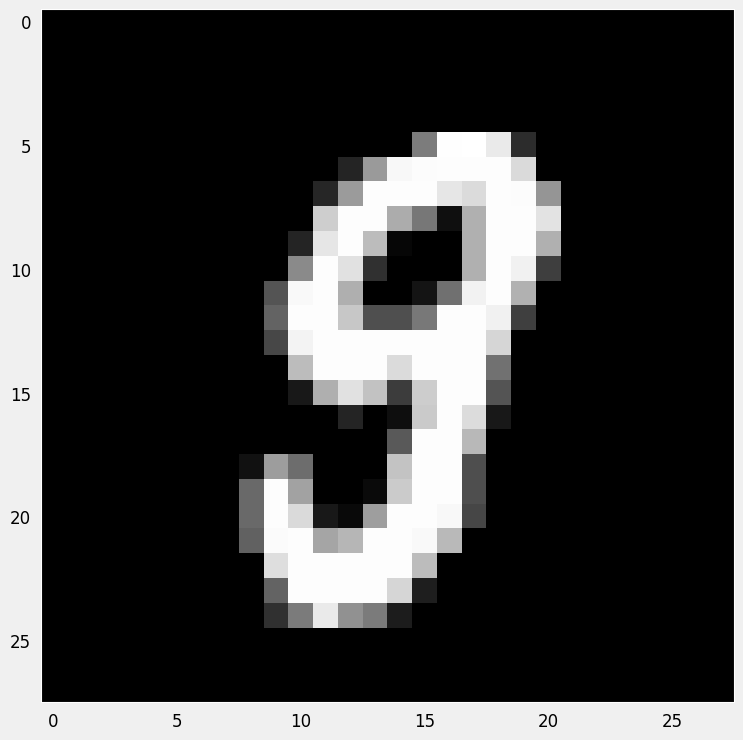

[8.6943130e-04 1.8333671e-08 8.8977683e-03 5.5351949e-01 1.1848311e-06
 4.3409115e-01 2.8395138e-05 1.3006368e-05 2.5782173e-03 1.3656781e-06]
[4.60521769e-05 6.83962890e-06 8.21199792e-05 7.94230461e-01
 8.51625714e-07 1.95842803e-01 3.68802171e-06 1.12029324e-04
 9.04275384e-03 6.32383453e-04]
[1.9130346e-05 6.8047939e-08 2.8903680e-03 9.9478203e-01 5.0128342e-06
 1.2039583e-04 5.5458372e-07 1.1970152e-05 1.4963718e-03 6.7402102e-04]
[3.3433055e-06 1.3700573e-01 8.4856707e-01 1.2433532e-02 2.1082252e-07
 1.0188904e-04 1.0382775e-03 1.8895855e-06 8.4768742e-04 4.2990075e-07]
[1.88952588e-04 2.20820539e-06 6.88280538e-02 9.30037379e-01
 2.84714218e-07 6.50263100e-04 5.45834382e-08 2.12231066e-06
 2.90650089e-04 1.00818774e-07]
[4.2542757e-04 2.6849452e-06 8.9837023e-04 8.8652385e-05 1.3500779e-02
 2.6446025e-04 1.5387571e-04 1.0476368e-01 2.8604462e-03 8.7704170e-01]
[1.53252040e-06 9.85782266e-01 4.44690790e-03 2.02989276e-03
 1.01473255e-04 2.99297444e-05 4.90145874e-04 1.48580910e-0

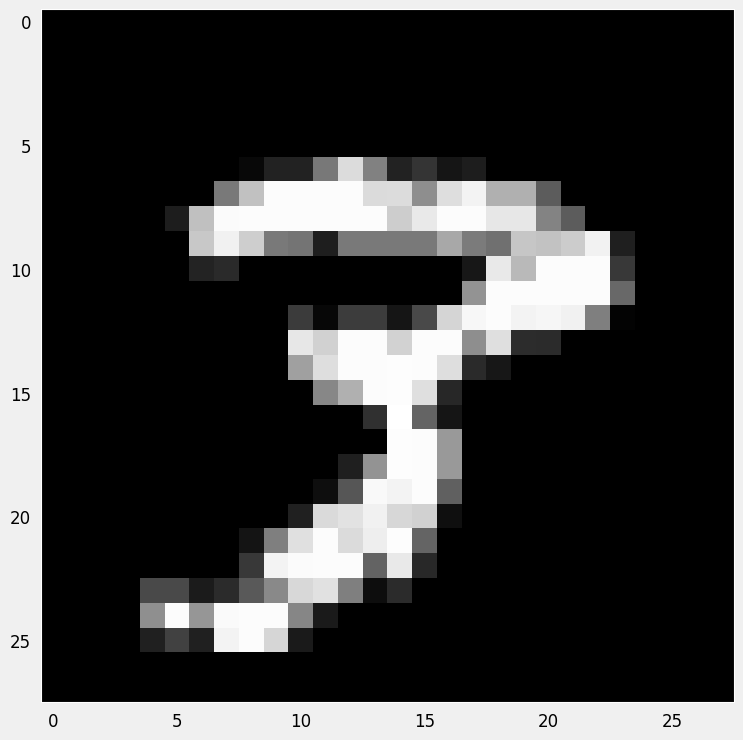

[1.7353350e-05 3.9570159e-06 5.8601527e-05 9.9014282e-02 3.2469136e-06
 3.3660419e-02 2.7350816e-07 6.8429776e-02 7.3843551e-01 6.0376607e-02]
[1.9999432e-04 5.1627732e-05 1.1908049e-03 5.8905282e-03 8.5799821e-04
 6.3909865e-03 6.1727165e-05 2.2958475e-06 9.8049998e-01 4.8539401e-03]
[1.0020076e-05 1.5271844e-03 9.5070928e-01 2.4750918e-02 4.1963381e-06
 1.9455711e-04 4.9852807e-04 1.2673687e-02 9.1578867e-03 4.7380535e-04]
[1.3809920e-03 9.8152552e-05 2.7508721e-01 1.6521124e-02 1.1003688e-03
 7.7563353e-05 3.3737113e-05 2.8594926e-01 3.1108584e-02 3.8864303e-01]
7


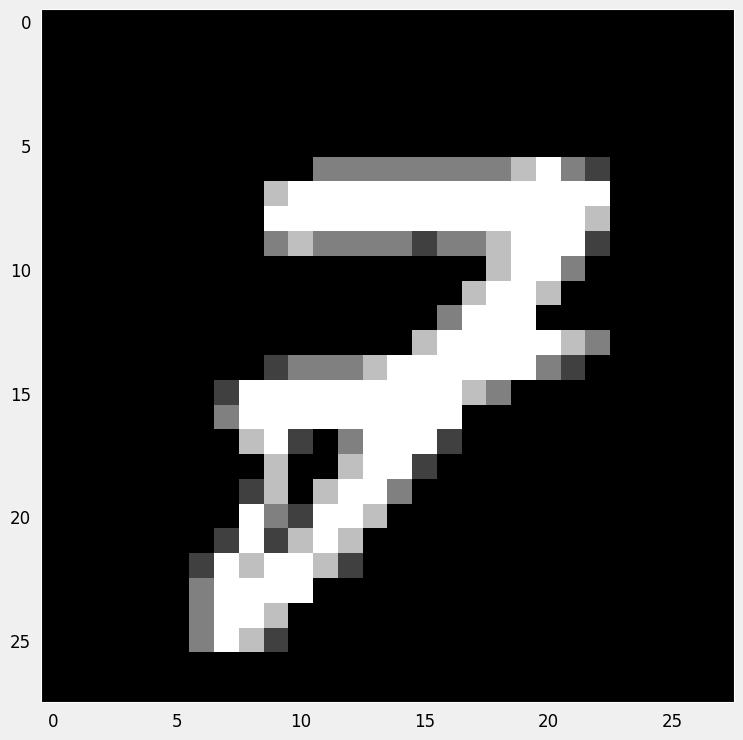

[9.1492737e-05 3.5440905e-07 6.4974627e-04 1.0847995e-02 2.0097013e-04
 5.0095987e-01 5.7880911e-06 2.8641682e-06 4.8588350e-01 1.3574731e-03]
[1.4390901e-03 5.5078010e-04 1.3430154e-02 1.8956032e-02 2.6591084e-04
 3.9563708e-02 9.5674688e-05 2.1300432e-06 9.2541862e-01 2.7789269e-04]
[1.9069760e-04 2.8465649e-05 2.3421335e-04 1.0395712e-02 7.3741707e-03
 1.7561067e-03 2.4419828e-04 1.1667841e-01 2.3080176e-03 8.6079001e-01]
[2.7323168e-04 2.2403678e-07 5.0328281e-03 2.8093034e-05 8.5600149e-03
 9.5444557e-06 9.8520571e-01 1.8907733e-04 1.6817606e-04 5.3316529e-04]
[3.0604631e-04 9.0272605e-01 3.5284890e-03 2.2407323e-02 2.7901999e-04
 2.5180595e-02 4.7112675e-03 4.0168860e-03 2.9993957e-02 6.8503702e-03]
[5.1327894e-04 1.8144445e-05 9.4932300e-04 4.4939551e-03 4.2760477e-04
 2.1519933e-03 2.2442116e-05 3.7027799e-05 9.6693492e-01 2.4451394e-02]
[8.0259397e-06 1.0317895e-10 5.8065798e-05 1.6990185e-05 9.9690741e-01
 5.2930000e-07 6.6849963e-05 3.5208593e-06 4.9730937e-04 2.4412740e-03]

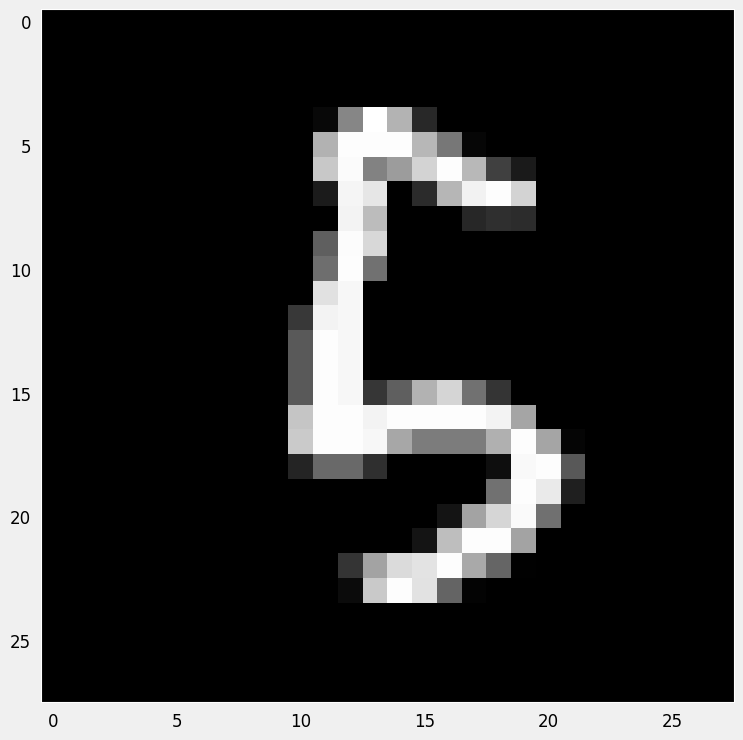

[7.6287421e-03 6.4974076e-05 9.5473342e-03 5.1987296e-01 2.2556137e-02
 9.8271668e-02 1.5470029e-04 1.2394839e-02 2.6997852e-01 5.9530187e-02]
9


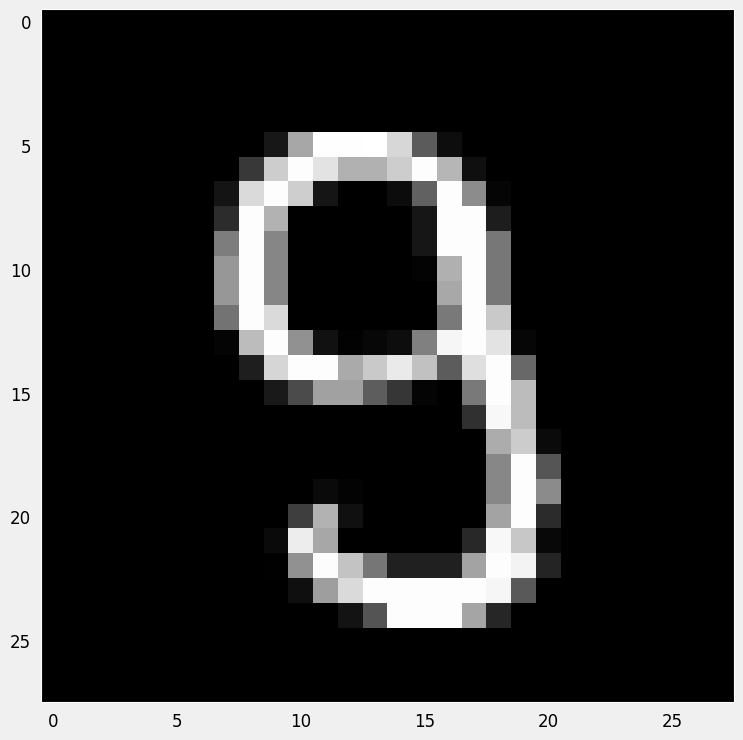

[2.5161458e-04 9.5152670e-01 9.0771457e-03 6.5559670e-03 3.8231848e-04
 1.8184449e-03 3.0796230e-03 1.7161889e-03 2.4890391e-02 7.0167962e-04]
[1.6495782e-05 1.4369585e-05 3.4168569e-04 1.7706366e-02 2.1033477e-02
 1.4663107e-03 7.1789022e-05 1.7844047e-02 3.6593287e-03 9.3784612e-01]
[2.5170206e-05 2.1018963e-07 6.6576910e-04 1.9874010e-02 7.0387154e-07
 5.2988339e-06 1.7545445e-07 9.7939074e-01 1.0601008e-05 2.7384656e-05]
[1.0009907e-01 1.2416602e-03 7.0154207e-04 4.2357549e-04 8.0721164e-03
 7.2453487e-01 5.0742491e-03 8.6001411e-02 6.4584181e-02 9.2673125e-03]
[4.2176030e-06 7.5830380e-06 1.1436869e-04 2.2465520e-04 9.6315175e-01
 1.9531342e-04 5.9985573e-04 2.6694615e-03 1.3293236e-03 3.1703271e-02]
[9.4953233e-01 2.4578134e-07 4.7701742e-03 2.5614130e-03 9.2581395e-05
 3.4557782e-02 1.2691480e-03 6.8816524e-05 6.9901571e-03 1.5737244e-04]
[3.6926318e-05 5.2644486e-07 6.4149598e-04 2.2773295e-04 3.0661635e-02
 9.1625243e-02 1.5096694e-04 2.0603361e-03 8.6111945e-01 1.3475698e-02]

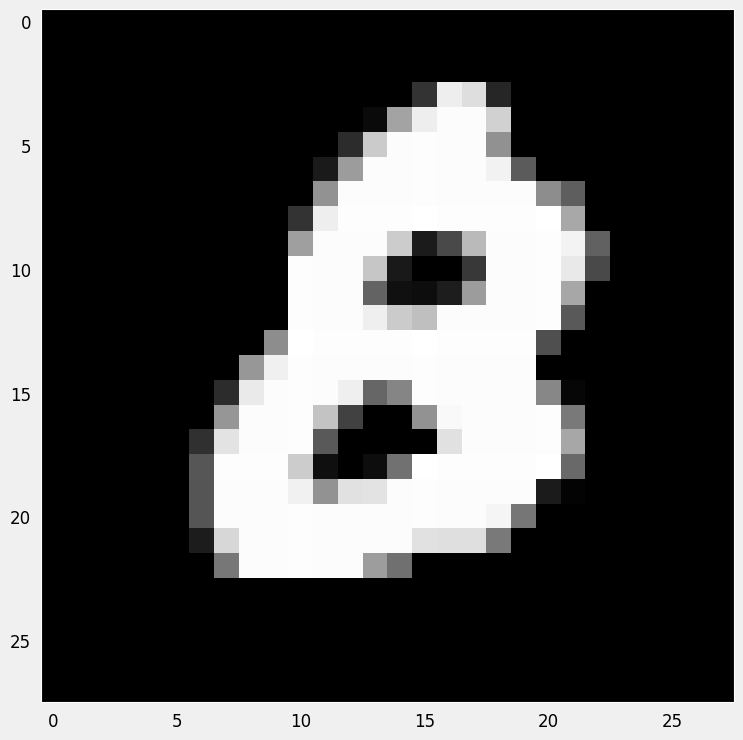

[1.2597667e-05 1.2354141e-04 1.4173620e-03 2.8147383e-03 4.1736305e-02
 2.8521888e-04 7.5634784e-04 1.0600867e-02 6.1448817e-03 9.3610823e-01]
[7.9114689e-06 2.6239034e-02 2.3276631e-03 9.9626333e-03 7.0616722e-01
 1.8116750e-02 9.3270536e-04 1.0082617e-02 1.7432080e-01 5.1842671e-02]
[9.3036187e-01 5.7236665e-08 3.7313781e-03 1.0945647e-04 2.0647328e-03
 1.6582772e-02 3.1187285e-03 2.5983999e-04 3.3924032e-02 9.8470207e-03]
[2.7485318e-03 4.2424232e-04 2.5904246e-02 1.8410907e-03 7.2684628e-03
 9.1109276e-03 9.2428058e-01 5.4012846e-05 2.7513603e-02 8.5443788e-04]


In [46]:
for i in range(500):
  y_hat=model.predict(x_test[i].reshape(-1, 784), verbose=0)
  print(y_hat[0])
  c=decode(y_test[i])
  if decode(y_hat[0]) != c:
    plt.imshow(x_test[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    print(c)
    plt.show()